In [25]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import json
import os
import numpy as np
import itertools
from collections import Counter

from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns

import notebook_utils as nbu

In [50]:
tokenizer_dir = "../../../tokenizers"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')
languages_old_order = ('ar', 'tr', 'zh','el', 'es', 'en')
multil_string = 'ar-tr-zh-el-es-en'

alphas = ('0.0', '0.25', '0.5', '0.75', '1.0')
# alphas_num = np.array([float(alpha) for alpha in alphas])
NV_multi = 120000
tok_type = "sp-unigram"

# load the statistics from monolingual corpora created using the multilingual tokenizer
token_stats = {}
for alpha in alphas:
    token_stats[alpha] = {}
    for lang in languages:
        tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram", multil_string, f"alpha-{alpha}_N-120000", f"token_freq_{lang}_{alpha}.json")
        with open(tokenizer_stats_path) as f:
            token_stats[alpha][lang] = json.load(f)

# load the all-training-data multilingual tokenizer statistics
overall_token_stats = {}
for alpha in alphas:
    tokenizer_stats_path = os.path.join(tokenizer_dir, "sp-unigram", multil_string, f"alpha-{alpha}_N-120000", f"token_frequencies.json")
    with open(tokenizer_stats_path) as f:
        overall_token_stats[alpha] = json.load(f)

In [28]:
# create the distributions for each alpha and language
def distribution_from_stats(stats, NV):
    dist = np.zeros(NV)
    assert len(stats) == NV
    for token, freq in stats.items():
        dist[int(token)] = freq
    dist /= dist.sum()
    return dist

token_dists = {}
overall_token_dists = {}
for alpha in alphas:
    token_dists[alpha] = {}
    for lang in languages:
        token_dists[alpha][lang] = distribution_from_stats(token_stats[alpha][lang], NV_multi)
    
    overall_token_dists[alpha] = distribution_from_stats(overall_token_stats[alpha], NV_multi)

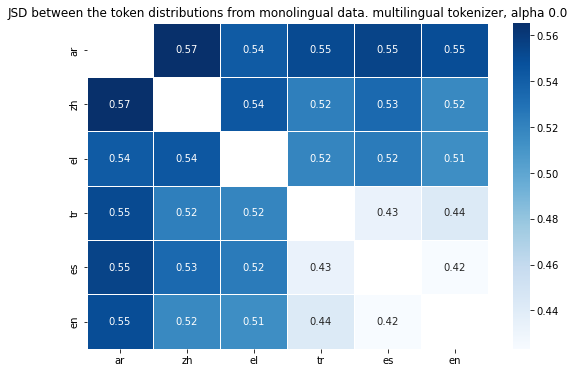

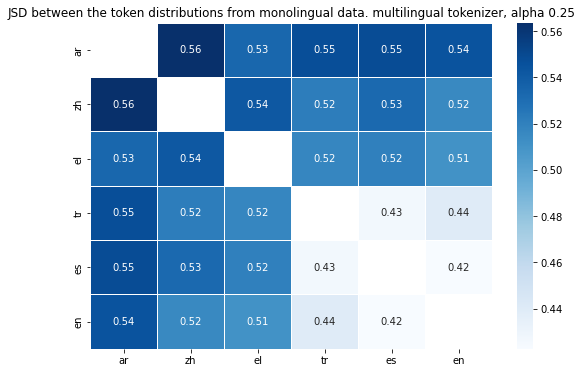

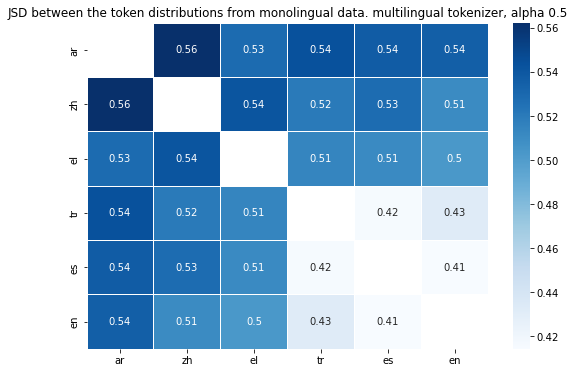

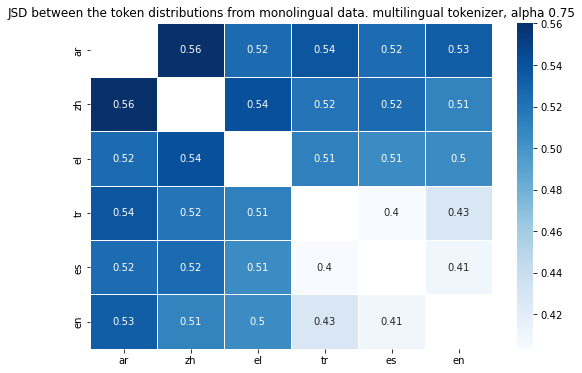

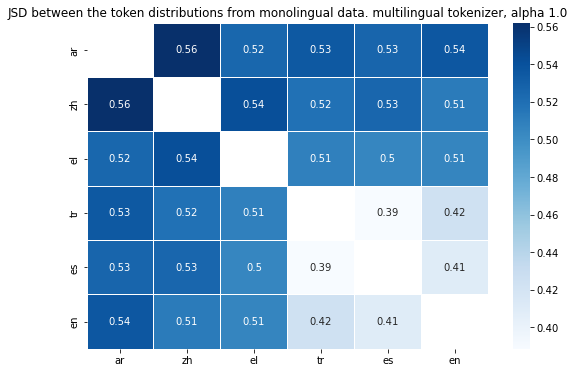

In [37]:
# compute the Jensen–Shannon divergence between the distributions
from scipy.spatial.distance import jensenshannon

jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1, lang2 in itertools.product(languages, languages):
        # to get the divergence, we need to square the JS-distances
        jds[alpha][(lang1, lang2)] = jensenshannon(token_dists[alpha][lang1], token_dists[alpha][lang2]) ** 2

# plot the KL divergence as a heatmap
for alpha in alphas:
    # plt.figure(figsize=(10, 10))
    divergences = np.array([[jds[alpha][(lang1, lang2)] for lang1 in languages] for lang2 in languages])

    f, ax = plt.subplots(figsize=(9, 6))
    # mask = np.zeros_like(divergences, dtype=np.bool)
    mask = np.eye(divergences.shape[0], dtype='bool')
    sns.heatmap(divergences, mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")

    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"JSD between the token distributions from monolingual data. multilingual tokenizer, alpha {alpha}")
    plt.show()

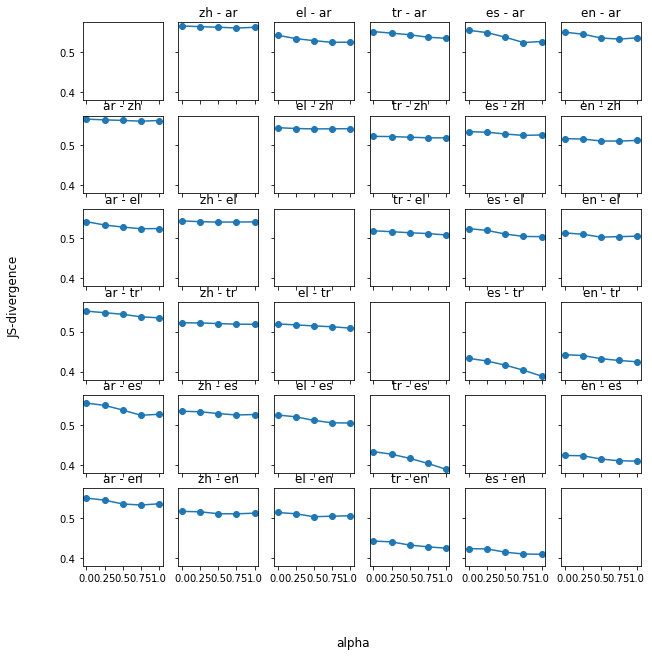

In [41]:
# plot the JS divergence as a grid of plots (one for each language pair) with x = alpha and y = divergence
fig, axes = plt.subplots(len(languages), len(languages), figsize=(10, 10), sharex=True, sharey=True)
for lang1, lang2 in itertools.product(languages, languages):
    if lang1 == lang2:
        continue
    ax = axes[languages.index(lang2), languages.index(lang1)]
    ax.plot(alphas, [jds[alpha][(lang1, lang2)] for alpha in alphas], marker='o')
    ax.set_title(f"{lang1} - {lang2}")
    # ax.set_xlabel("alpha")
    # ax.set_ylabel("JS-divergence")
fig.supxlabel("alpha")
fig.supylabel("JS-divergence")
plt.show()

- observation: the divergences never go higher with more data


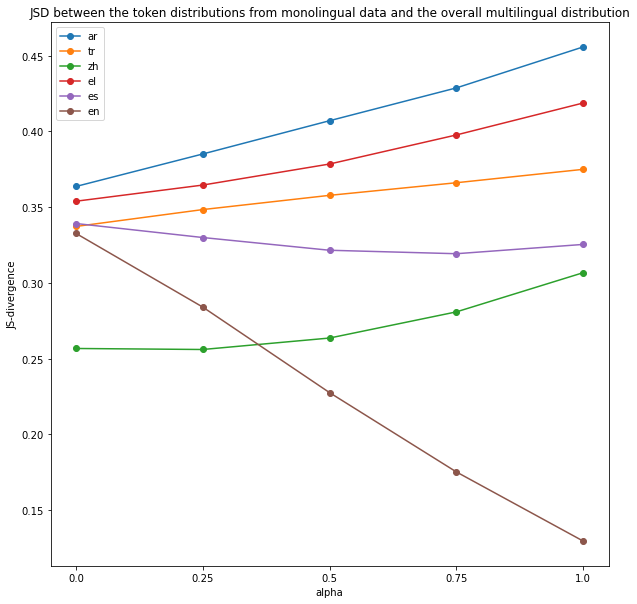

In [51]:
# compute the Jensen–Shannon divergence between the monolingual distributions and the overall distribution
jds = {}
for alpha in alphas:
    jds[alpha] = {}
    for lang1 in languages:
        jds[alpha][lang1] = jensenshannon(token_dists[alpha][lang1], overall_token_dists[alpha]) ** 2

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([jds[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([jds[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("JS-divergence")
plt.title("JSD between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

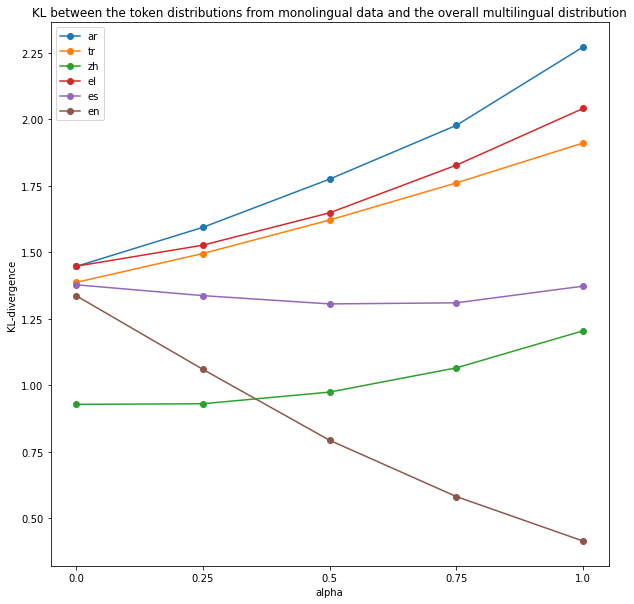

In [52]:
# compute the KL divergence between the monolingual distributions and the overall distribution
from scipy.stats import entropy

kls = {}
for alpha in alphas:
    kls[alpha] = {}
    for lang1 in languages:
        kls[alpha][lang1] = entropy(token_dists[alpha][lang1], overall_token_dists[alpha])

# plot the KL divergence
plt.figure(figsize=(10, 10))
# for alpha in alphas:
#     divergences = np.array([kls[alpha][lang] for lang in languages])
#     plt.plot(alphas, divergences, marker='o', label=f"alpha {alpha}")
for lang in languages_old_order:
    divergences = np.array([kls[alpha][lang] for alpha in alphas])
    plt.plot(alphas, divergences, marker='o', label=f"{lang}")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("KL-divergence")
plt.title("KL between the token distributions from monolingual data and the overall multilingual distribution")
plt.show()

In [5]:
vocab_sizes = {alpha: {lang: len(token_stats[alpha][lang]) for lang in all_languages} for alpha in alphas}

Peculiarly, some of the tokens are used 0 times in the training data. 

In [6]:
ub = nbu.UnicodeBlocks("unicode_blocks.tsv")

char_stats = nbu.get_char_stats(token_stats, all_languages, alphas, lambda x: x, skip_tokens=["<s>", "</s>"])
unicode_blocks_stats = nbu.get_char_stats(token_stats, all_languages, alphas, ub.get_block, skip_tokens=["<s>", "</s>"])

### Measure size of alphabet in the vocab

In [7]:
# compute alphabet occurences
alphabet_occurence = nbu.apply_to_all_token_stats(token_stats, nbu.get_alphabet_occurence)
pd_alphabet_occurence = nbu.stats_to_pandas(alphabet_occurence)
total_occurence = nbu.apply_to_all_token_stats(token_stats, nbu.get_total_occurence)
pd_total_occurence = nbu.stats_to_pandas(total_occurence)

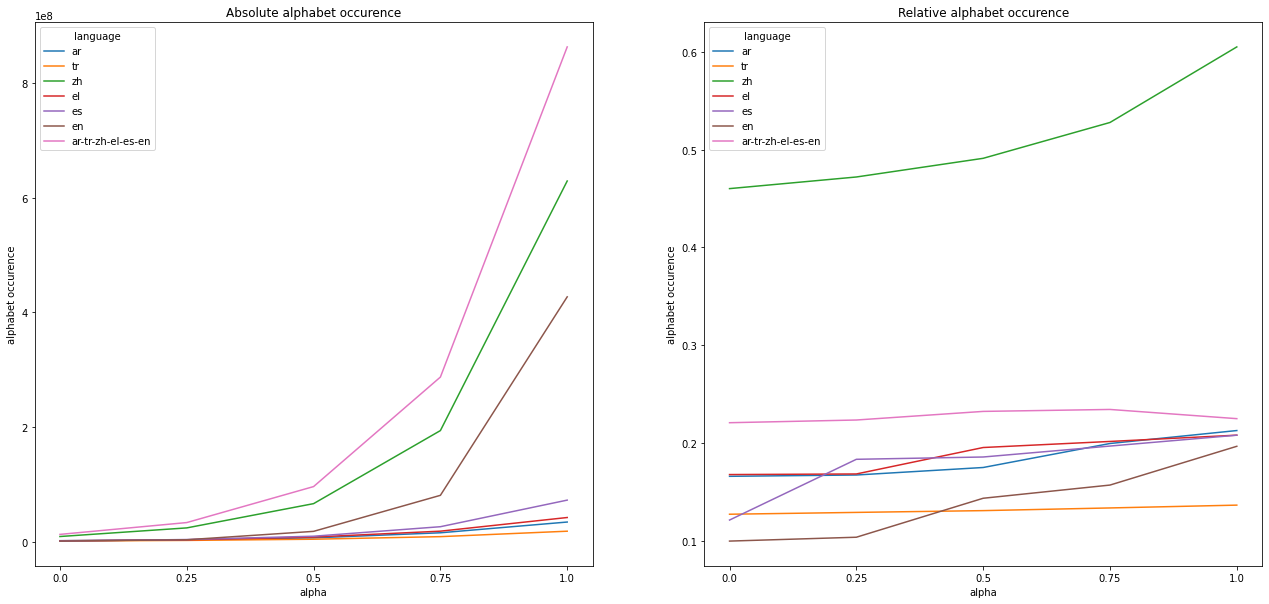

In [8]:
pd_relative_alphabet_occurence = pd_alphabet_occurence / pd_total_occurence

# plot the absolute and relative alphabet occurence
# x will be the alpha values
# y will be the absolute and relative occurence
# hue will be the language

fig, ax = plt.subplots(1, 2, figsize=(22, 10))
sns.lineplot(data=pd_alphabet_occurence, x="alpha", y="value", hue="language", ax=ax[0])
sns.lineplot(data=pd_relative_alphabet_occurence, x="alpha", y="value", hue="language", ax=ax[1])
# set titles and labels
ax[0].set_title("Absolute alphabet occurence")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("alphabet occurence")
ax[1].set_title("Relative alphabet occurence")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("alphabet occurence")
plt.show()

In [9]:
# plt.figure()

# for lang, alphabet_size in alphabet_sizes.items():
#     if lang == "multilingual":
#         plt.plot(alphas_num, alphabet_size/NV_multi, label=lang, alpha=0.6)
#     else:
#         plt.plot(alphas_num, alphabet_size/NV_mono, label=lang, alpha=0.6)
    
# plt.xlabel("Alpha")
# plt.ylabel("Alphabet as share of vocab")
# plt.legend()

In [10]:
# compute overlaps
skip_tokens = ["<s>", "</s>"]
overlap_maps = {}
overlap_tokens = []
overlap_blocks = []
for alpha in alphas:
    # go through all language pairs with replacement
    overlap_list = []
    for lang1, lang2 in itertools.product(all_languages, repeat=2):
        # compute how many times tokens shared between lang1 and lang2 occur in lang2
        shared_tokens = token_stats[alpha][lang1].keys() & token_stats[alpha][lang2].keys()
        # filter out special tokens
        shared_tokens = [token for token in shared_tokens if token not in skip_tokens]
        shared_token_freqs = [(token, token_stats[alpha][lang2][token]) for token in shared_tokens]
        shared_token_freqs.sort(key=lambda x: x[1], reverse=True)

        special_token_freqs = [(token, token_stats[alpha][lang2][token]) for token in skip_tokens]

        # get total token count for lang2
        total = total_occurence[alpha][lang2] - sum([freq for token, freq in special_token_freqs])
        shared = sum([freq for token, freq in shared_token_freqs])
        
        # print(alpha, lang1, lang2, total, shared, shared/total, shared_token_freqs[:10])
        # overlap = nbu.get_overlap(token_stats[alpha][lang1], token_stats[alpha][lang2])
        # overlaps[(alpha, lang1, lang2)] = overlap
        overlap_list.append(shared/total)
        for token, freq in shared_token_freqs[:20]:
            overlap_tokens.append({
                "alpha": alpha,
                "lang1": lang1,
                "lang2": lang2,
                "token": token,
                "freq": freq/total
            })
        char_stats = nbu.compute_char_stats(dict(shared_token_freqs), ub.get_block, skip_tokens)
        char_stats = list(char_stats.items())
        char_total = sum(freq for _, freq in char_stats)
        char_stats.sort(key=lambda x: x[1], reverse=True)

        for block, freq in char_stats[:20]:
            overlap_blocks.append({
                "alpha": alpha,
                "lang1": lang1,
                "lang2": lang2,
                "block": block,
                "freq": freq/char_total
            })
    overlap_maps[alpha] = np.array(overlap_list).reshape((len(all_languages), len(all_languages)))

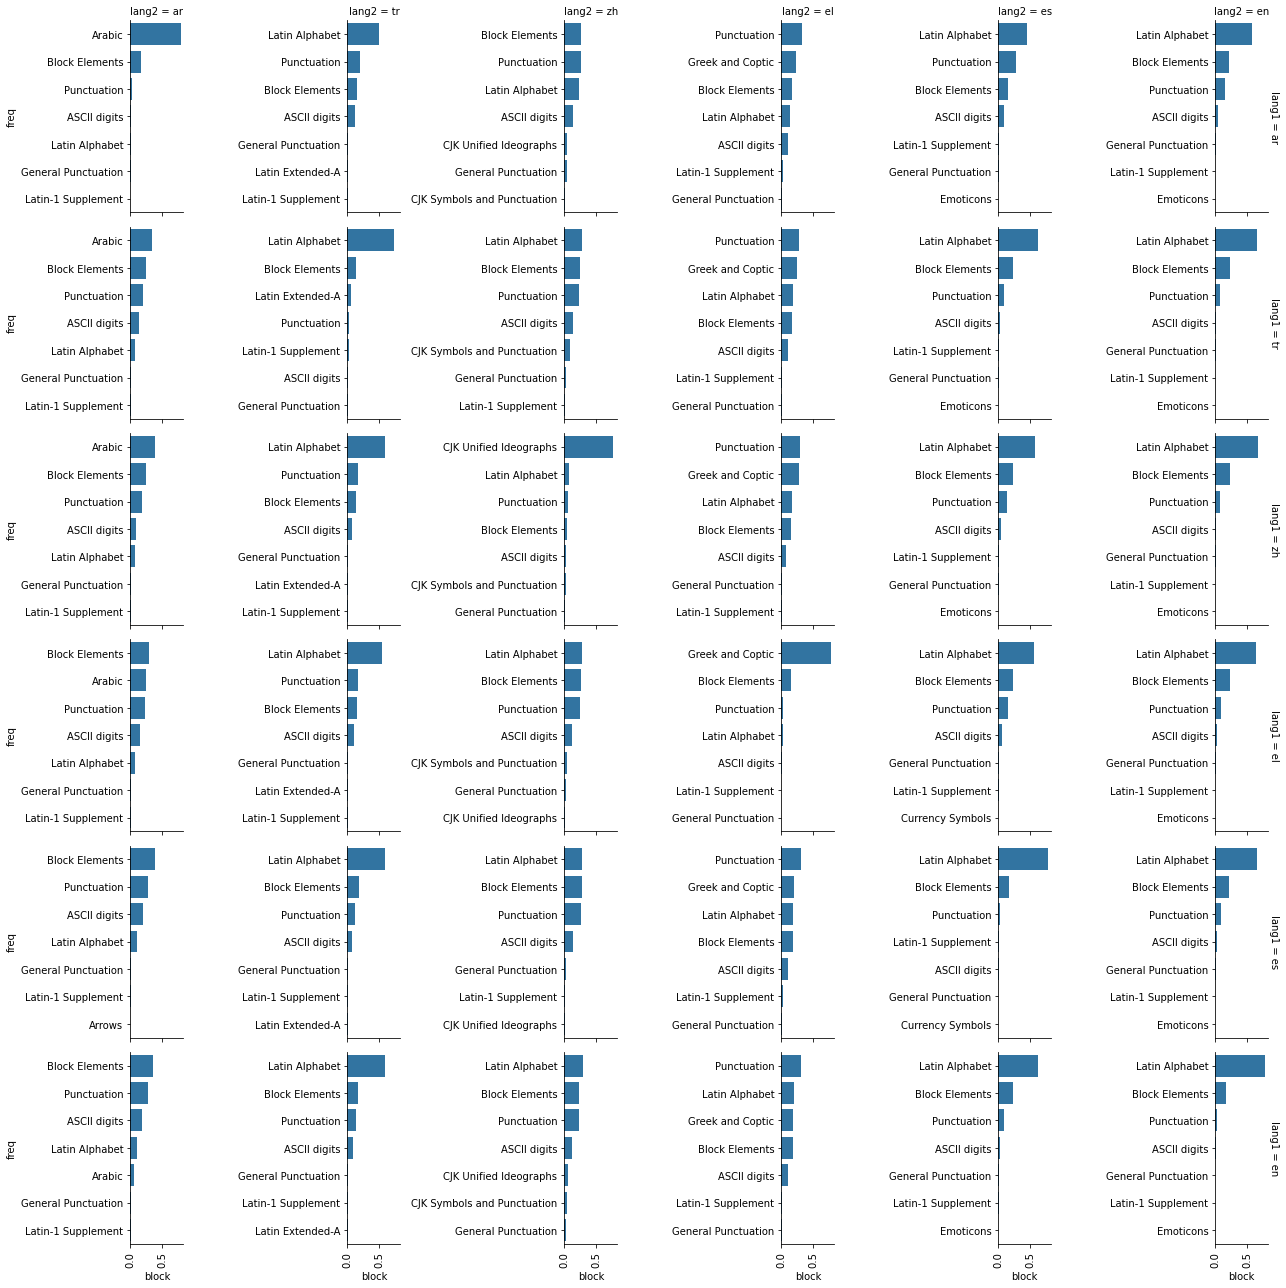

In [15]:
import pandas as pd
overlap_blocks = pd.DataFrame(overlap_blocks)
# select alpha 0.0
overlap_blocks_0 = overlap_blocks[overlap_blocks["alpha"] == "0.0"]
# filter out multilingual ("ar-tr-zh-el-es-en") lang1 and lang2
overlap_blocks_0 = overlap_blocks_0[overlap_blocks_0["lang1"] != "ar-tr-zh-el-es-en"]
overlap_blocks_0 = overlap_blocks_0[overlap_blocks_0["lang2"] != "ar-tr-zh-el-es-en"]
# plot these overlap blocks as a pairwise piegraph in a grid. x axis is lang2 and y axis is lang1. Each piegraph shows the top 5 blocks
g = sns.FacetGrid(overlap_blocks_0, col="lang2", row="lang1", margin_titles=True, sharey=False)
# set xlabel to Language 2 (target language)
g.set_axis_labels("Language 2 (target language)", "Language 1 (source language)")
def _plot_one(labels, freqs, **kwargs):
    # filter first n blocks
    labels=labels[:7]
    freqs=freqs[:7]
    # rotate labels 90 degrees
    plt.xticks(rotation=90)
    
    sns.barplot(x=freqs, y=labels, order=labels, **kwargs)
g.map(_plot_one, "block", "freq", data=overlap_blocks_0)


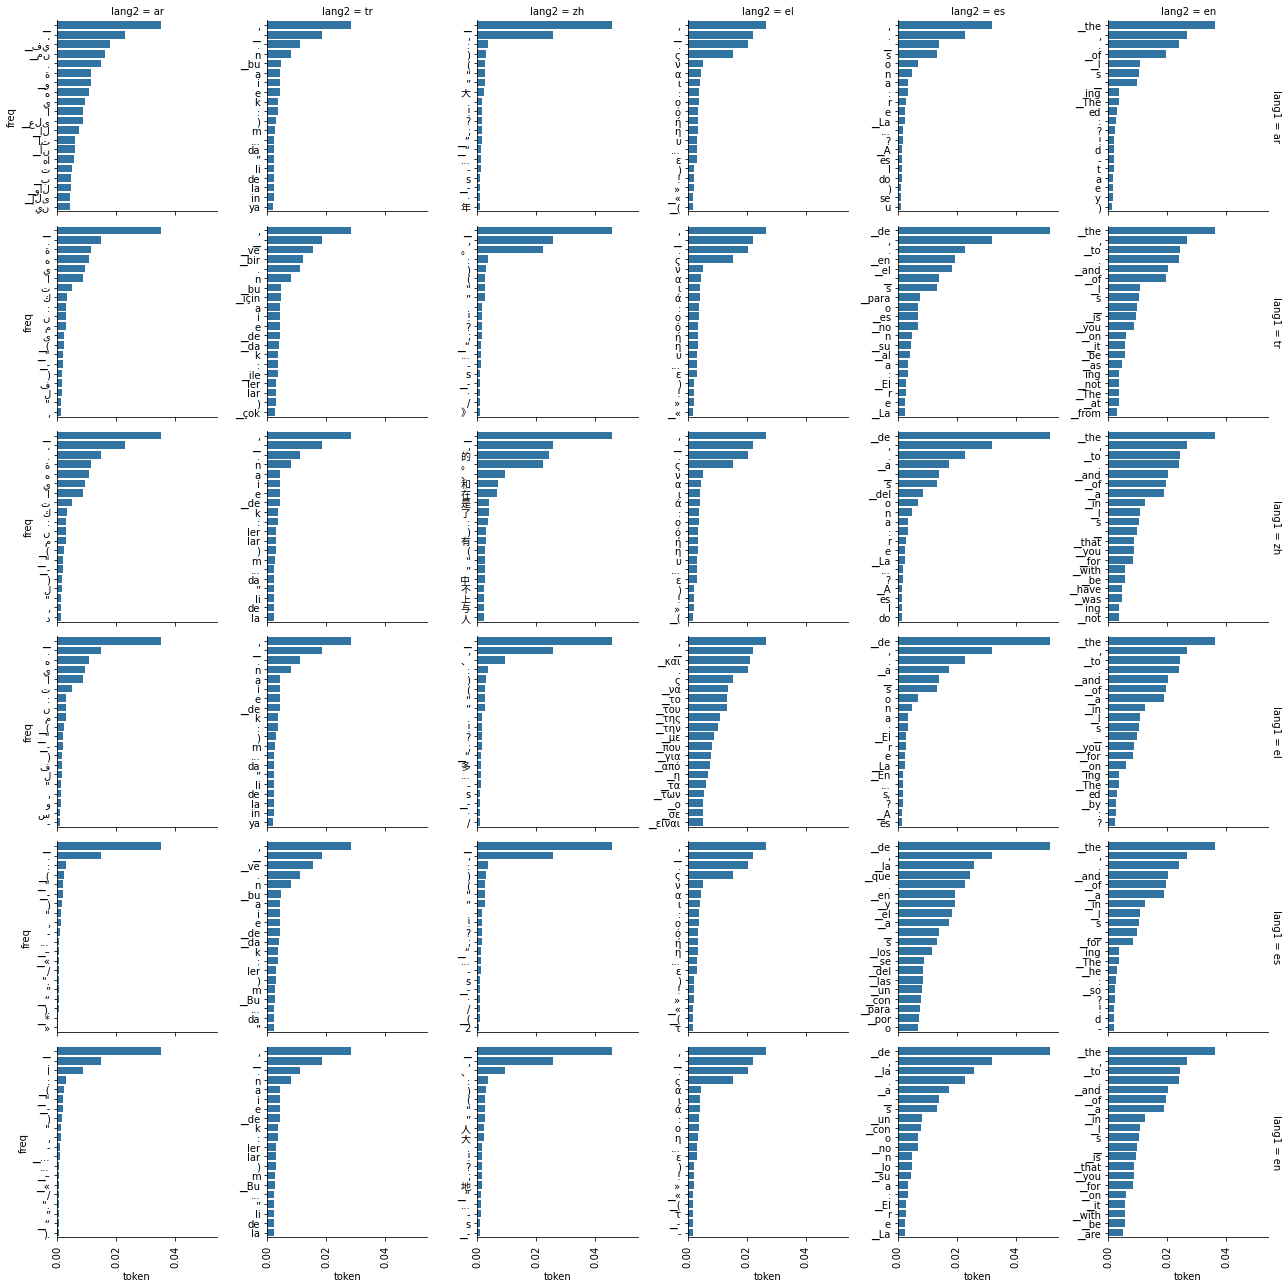

In [23]:
# set the fonts to show all characters
import matplotlib
matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'Droid Sans', 'Noto Sans CJK JP']

# now plot most frequent shared tokens
overlap_tokens = pd.DataFrame(overlap_tokens)
# select alpha 0.0
overlap_tokens_0 = overlap_tokens[overlap_tokens["alpha"] == "0.0"]
# filter out multilingual ("ar-tr-zh-el-es-en") lang1 and lang2
overlap_tokens_0 = overlap_tokens_0[overlap_tokens_0["lang1"] != "ar-tr-zh-el-es-en"]
overlap_tokens_0 = overlap_tokens_0[overlap_tokens_0["lang2"] != "ar-tr-zh-el-es-en"]
g = sns.FacetGrid(overlap_tokens_0, col="lang2", row="lang1", margin_titles=True, sharey=False)
# set xlabel to Language 2 (target language)
g.set_axis_labels("Language 2 (target language)", "Language 1 (source language)")
def _plot_one(labels, freqs, **kwargs):
    # filter first n blocks
    labels=labels[:20]
    freqs=freqs[:20]
    # rotate labels 90 degrees
    plt.xticks(rotation=90)
    
    sns.barplot(x=freqs, y=labels, order=labels, **kwargs)
g.map(_plot_one, "token", "freq", data=overlap_tokens_0)

In [29]:
pip install circlify

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


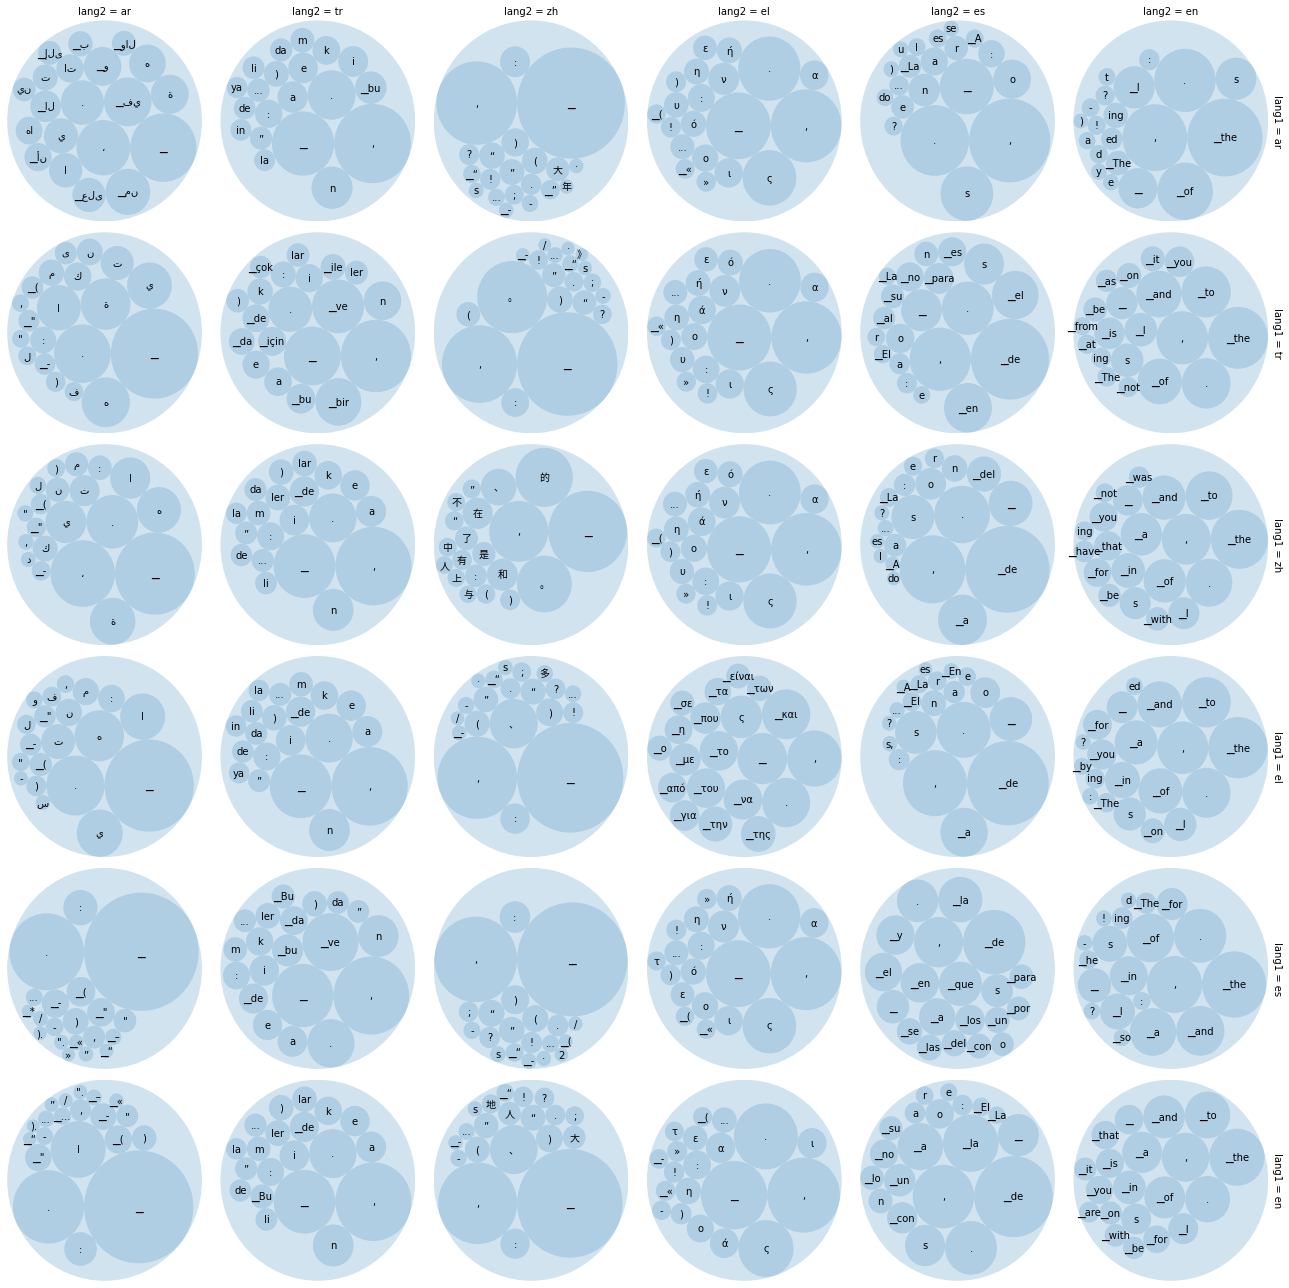

In [45]:
import circlify as circ

g = sns.FacetGrid(overlap_tokens_0, col="lang2", row="lang1", margin_titles=True, sharey=False)
# set xlabel to Language 2 (target language)
g.set_axis_labels("Language 2 (target language)", "Language 1 (source language)")
def _plot_one(labels, freqs, *args, **kwargs):
    # get current ax
    ax = plt.gca()

    data = [{"id": label, "datum": freq} for label, freq in zip(labels, freqs)]
    circles = circ.circlify(data, show_enclosure=True)

    # Remove axes
    ax.axis('off')

    # Find axis boundaries
    lim = max(
        max(
            abs(circle.x) + circle.r,
            abs(circle.y) + circle.r,
        )
        for circle in circles
    )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # print circles
    for circle in circles:
        x, y, r = circle
        # print(x, y, r, circle, circle.ex)
        ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2))
        if circle.ex is not None:
            plt.annotate(
                circle.ex["id"], 
                (x,y ) ,
                va='center',
                ha='center'
            )


g.map(_plot_one, "token", "freq")

<Figure size 432x288 with 0 Axes>

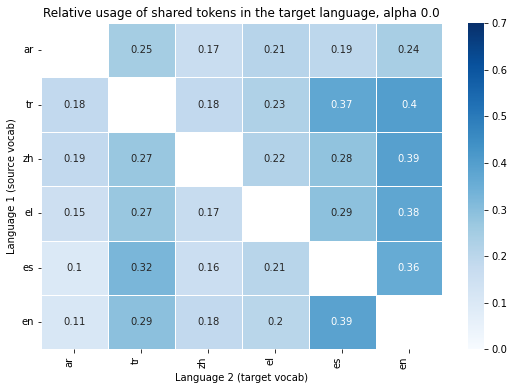

<Figure size 432x288 with 0 Axes>

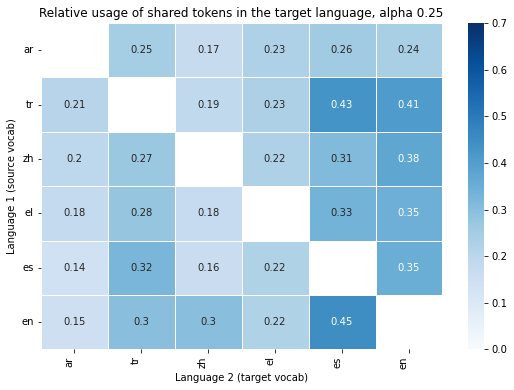

<Figure size 432x288 with 0 Axes>

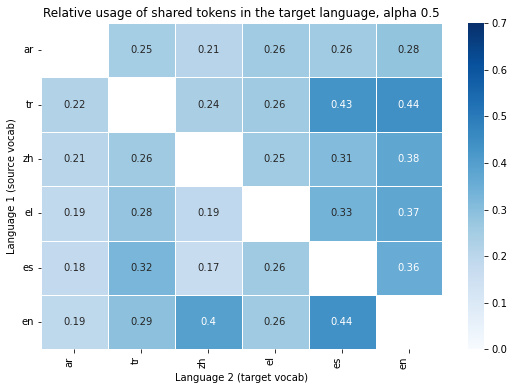

<Figure size 432x288 with 0 Axes>

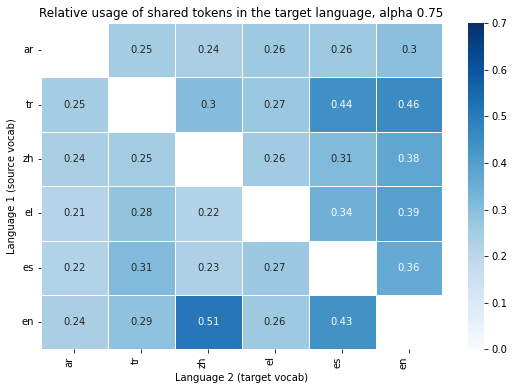

<Figure size 432x288 with 0 Axes>

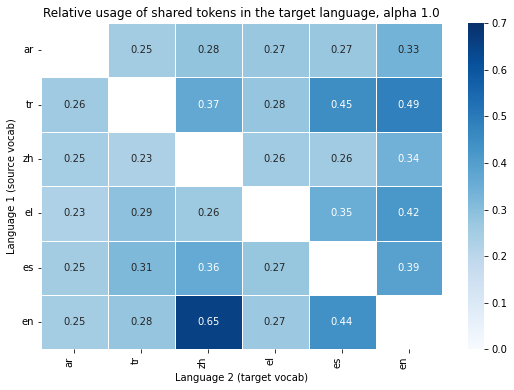

In [12]:
for alpha in alphas:
    plt.figure()


    f, ax = plt.subplots(figsize=(9, 6))
    mask = np.eye(overlap_maps[alpha][:-1,:-1].shape[0], dtype='bool')
    # mask[:,-1] = True
    sns.heatmap(overlap_maps[alpha][:-1,:-1], mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues", vmin=0, vmax=0.7)

    renamed_all_languages = [lang.replace("ar-tr-zh-el-es-en", "multi") for lang in all_languages]
    renamed_all_languages = renamed_all_languages[:-1]

    ax.set_xticks(np.arange(len(renamed_all_languages)) + 0.5, labels=renamed_all_languages)
    ax.set_yticks(np.arange(len(renamed_all_languages)) + 0.5, labels=renamed_all_languages)
    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
    # set labels
    ax.set_xlabel("Language 2 (target vocab)")
    ax.set_ylabel("Language 1 (source vocab)")
    # set the same saturation
    

    ax.set_title(f"Relative usage of shared tokens in the target language, alpha {alpha}")
    plt.show()

# Old cells below
----

### Measure token acceptance in m-lingual vocab

In [16]:
accepted_shares = {}
for lang in languages:
    accepted_shares[lang] = np.array([tokens_acceptance(mono_tokenizers[f"alpha{alpha}"][lang],
                                                       multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])


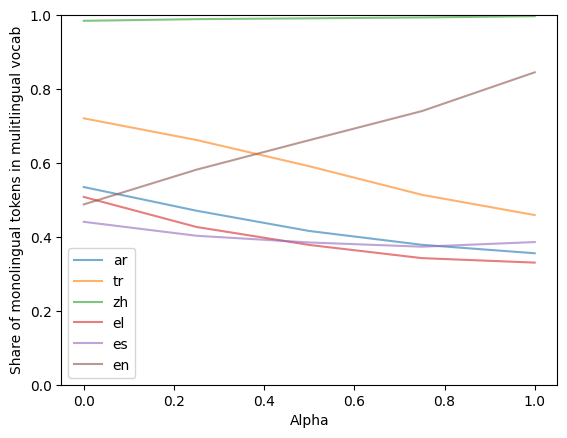

In [17]:
plt.figure()

for lang, accepted_share in accepted_shares.items():
        plt.plot(alphas_num, accepted_share, label=lang, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Share of monolingual tokens in mulitlingual vocab")
plt.ylim([0.0, 1.0])
plt.legend()

Without considering alphabet.

In [18]:
accepted_shares_no_alphabet = {}
for lang in languages:
    accepted_shares_no_alphabet[lang] = np.array([tokens_acceptance_no_alphabet(mono_tokenizers[f"alpha{alpha}"][lang],
                                                       multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

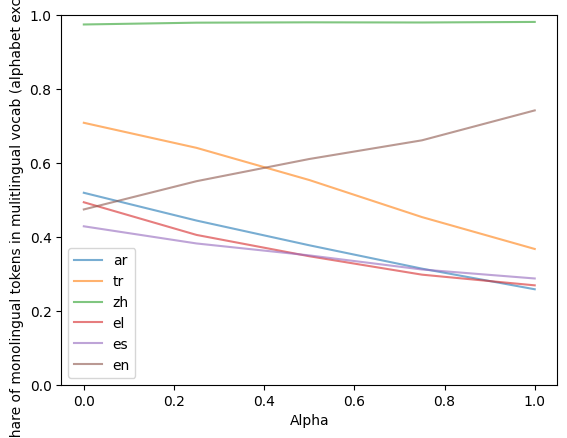

In [19]:
plt.figure()

for lang, accepted_share in accepted_shares_no_alphabet.items():
        plt.plot(alphas_num, accepted_share, label=lang, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Share of monolingual tokens in mulitlingual vocab (alphabet excluded)")
plt.ylim([0.0, 1.0])
plt.legend()

### Measure overlap between languages

In [20]:
all_overlap_shares_exact = np.array([tokens_overlap_exact([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages],
                                                    multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

all_overlap_shares = np.array([tokens_overlap([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages],
                                              multi_tokenizer[f"alpha{alpha}"]) for alpha in alphas])

In [21]:
np.abs(all_overlap_shares_exact - all_overlap_shares )

array([0., 0., 0., 0., 0.])

**exact means that we take into account mulilingual tokenizer in the intersection. It shouldn't have any influence because monolingual overlap should be included in it. In practice there are minor differences between two resulting sets.**

In [22]:
for alpha in alphas:
    print(f"Overlap for all languages for alpha: {alpha}")
    print_tokens_overlap([mono_tokenizers[f"alpha{alpha}"][lang] for lang in languages], multi_tokenizer[f"alpha{alpha}"])
    

Overlap for all languages for alpha: 0.0
['!', '"', '#', '$', '%', '&', "'", '(', ')', '):', '*', '+', ',', '-', '-1', '-12', '-2', '.', '...', '................', '.com', '.com/', '/', '0', '00', '000', '01', '04', '05', '06', '07', '08', '09', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '200', '2010', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '300', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '400', '42', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '55', '56', '57', '58', '59', '6', '60', '61', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '99', ':', ';', '<', '</s>', '<mask>', '<pad>', '<s>', '<unk>', '=', '>', '?', '@', 'A', 'AL', 'AN', 'B', 'Book', 'C', 'D', 'E', 'ER', 'F', 'G', 'GB', 'H', 'I', 'IP', 'IS', 'J

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '-1', '.', '...', '.com', '/', '0', '00', '000', '01', '02', '03', '04', '05', '07', '08', '09', '1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '200', '2017', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '400', '42', '44', '45', '46', '47', '48', '49', '5', '50', '52', '55', '56', '58', '6', '60', '600', '64', '65', '66', '68', '7', '70', '75', '77', '78', '8', '80', '88', '9', '90', '95', '96', '97', '98', '99', ':', ';', '<', '</s>', '<mask>', '<pad>', '<s>', '<unk>', '=', '>', '?', '@', 'A', 'AR', 'B', 'C', 'D', 'E', 'ER', 'F', 'G', 'H', 'I', 'ID', 'IN', 'IP', 'J', 'K', 'L', 'M', 'N', 'O', 'OS', 'P', 'PS', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'age', 'and', 'ang', 'ard', 'art', 'b', 'c', 'ca', 'ch', 'com', 'd', 'do', 'e', 'er', 'est', 'ex', 'f', 'g', '

Text(0, 0.5, 'Overlap between all languages')

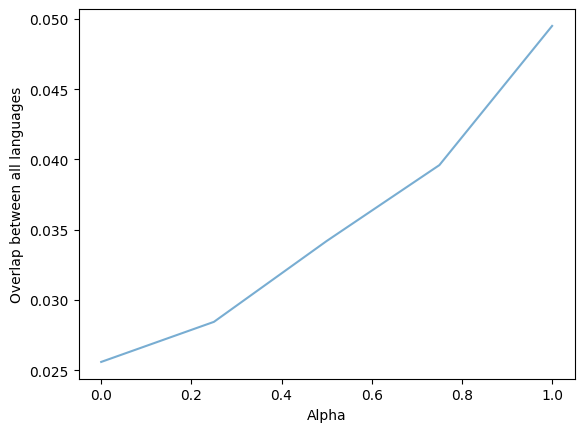

In [23]:
plt.figure()

plt.plot(alphas_num, all_overlap_shares_exact, alpha=0.6)
    
plt.xlabel("Alpha")
plt.ylabel("Overlap between all languages")



## Measuring Overlap between pairs of languages

In [24]:
overlap_maps = {}

for alpha in alphas:
    overlap_list = []
    for lang1, lang2 in itertools.product(languages, repeat=2):
        overlap_list.append(tokens_overlap([mono_tokenizers[f"alpha{alpha}"][lang1],
                                                 mono_tokenizers[f"alpha{alpha}"][lang2]],
                                               multi_tokenizer[f"alpha{alpha}"]))
        
    overlpa_matrix = np.array(overlap_list).reshape((len(languages), len(languages)))
    overlap_maps[f"alpha{alpha}"] = overlpa_matrix

<Figure size 640x480 with 0 Axes>

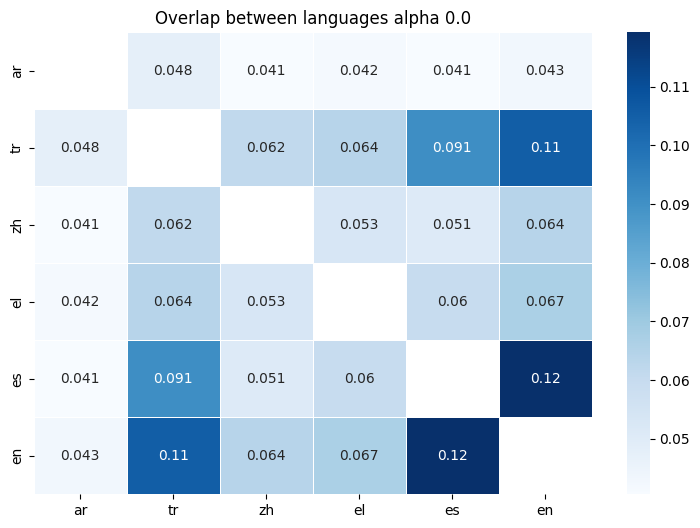

<Figure size 640x480 with 0 Axes>

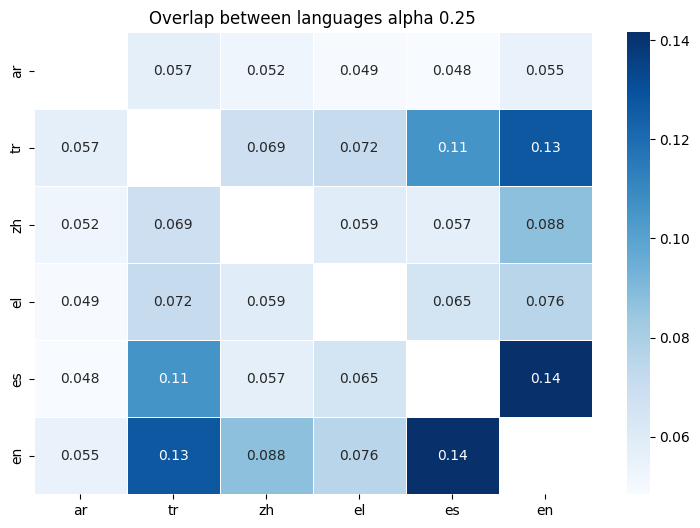

<Figure size 640x480 with 0 Axes>

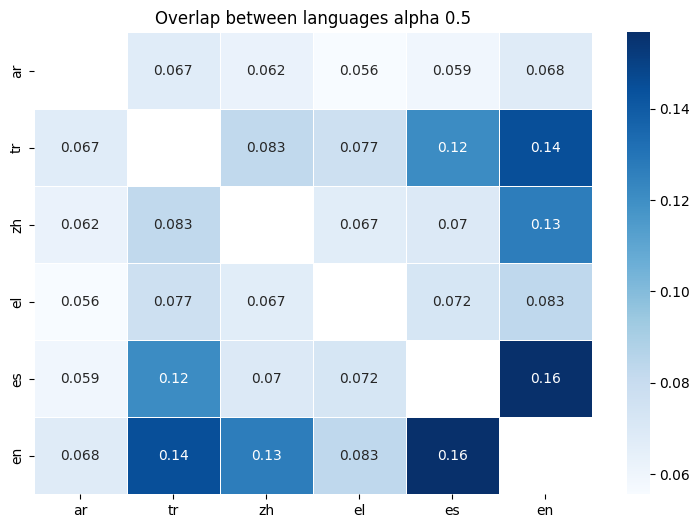

<Figure size 640x480 with 0 Axes>

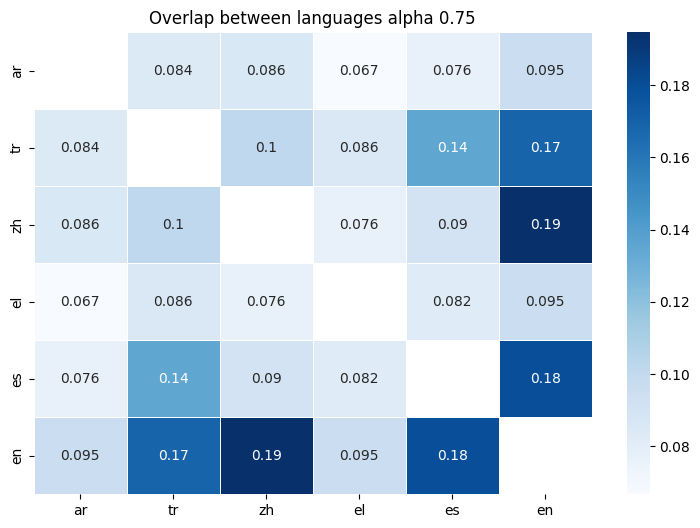

<Figure size 640x480 with 0 Axes>

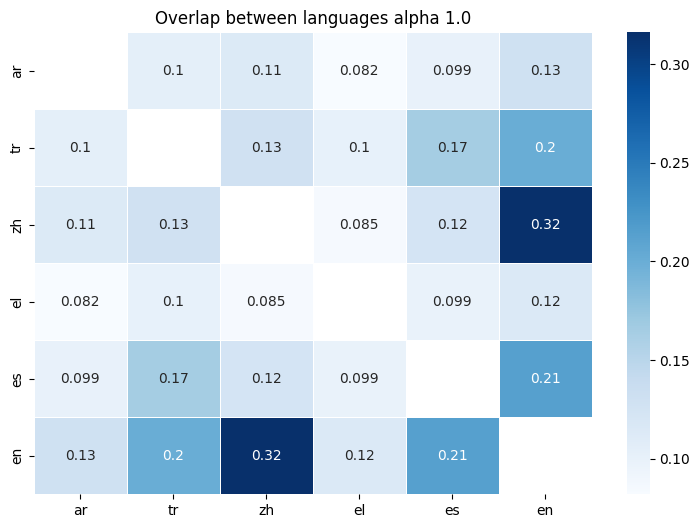

In [25]:
for alpha in alphas:
    plt.figure()


    f, ax = plt.subplots(figsize=(9, 6))
    mask = np.eye(overlap_maps[f"alpha{alpha}"].shape[0], dtype='bool')
    sns.heatmap(overlap_maps[f"alpha{alpha}"], mask=mask, annot=True, linewidths=.5, ax=ax, cmap="Blues")


    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"Overlap between languages alpha {alpha}")
    plt.show()

**Overlaps are so small because it's normalized for**

## Without alphabet

In [26]:
overlap_maps_no_alphabet = {}

for alpha in alphas:
    overlap_list = []
    for lang1, lang2 in itertools.product(languages, repeat=2):
        overlap_list.append(tokens_overlap_exact_no_alphabet([mono_tokenizers[f"alpha{alpha}"][lang1],
                                                 mono_tokenizers[f"alpha{alpha}"][lang2]],
                                               multi_tokenizer[f"alpha{alpha}"]))
        
    overlpa_matrix = np.array(overlap_list).reshape((len(languages), len(languages)))
    overlap_maps_no_alphabet[f"alpha{alpha}"] = overlpa_matrix

<Figure size 640x480 with 0 Axes>

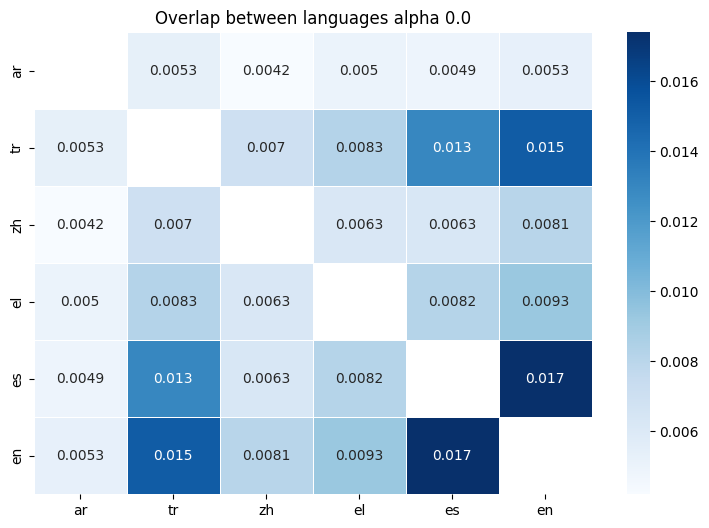

<Figure size 640x480 with 0 Axes>

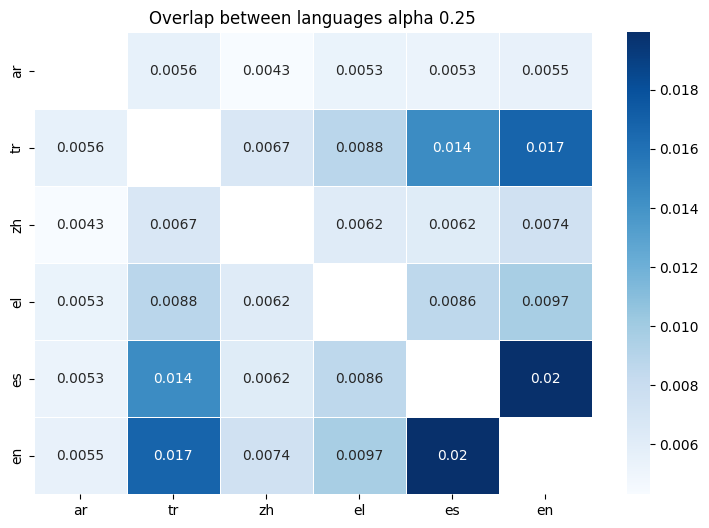

<Figure size 640x480 with 0 Axes>

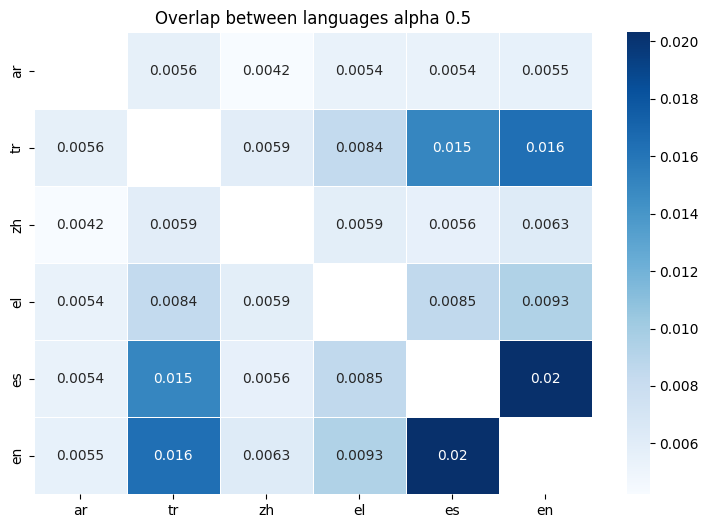

<Figure size 640x480 with 0 Axes>

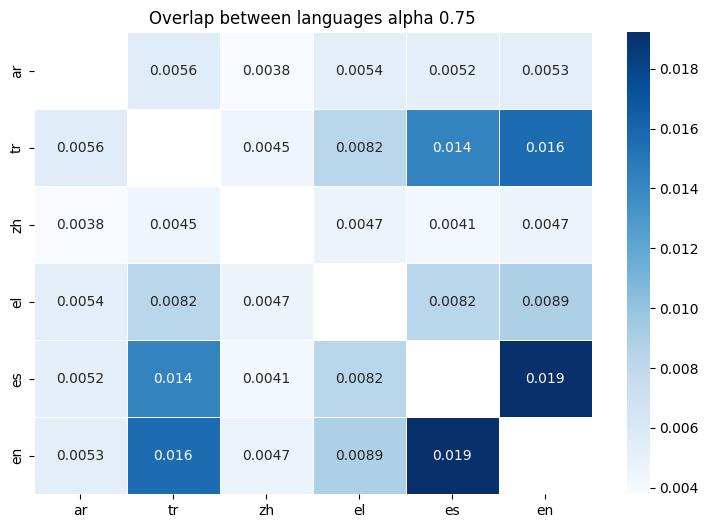

<Figure size 640x480 with 0 Axes>

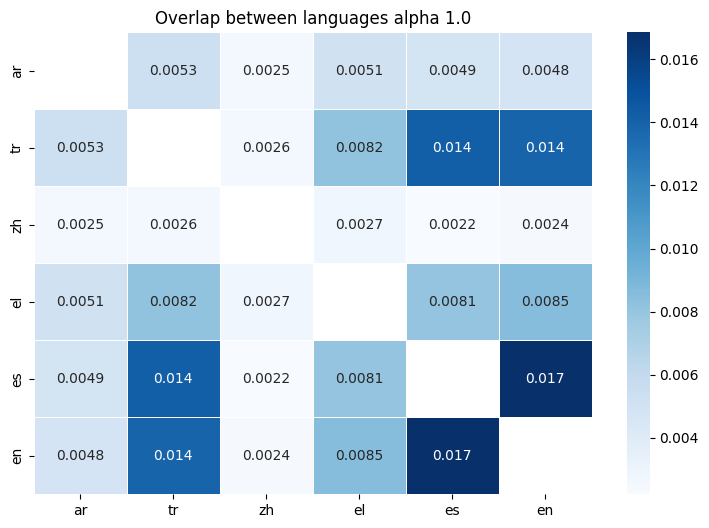

In [27]:
for alpha in alphas:
    plt.figure()


    
    f, ax = plt.subplots(figsize=(9, 6))
    mask = np.eye(overlap_maps_no_alphabet[f"alpha{alpha}"].shape[0], dtype='bool')
    sns.heatmap(overlap_maps_no_alphabet[f"alpha{alpha}"], annot=True, mask=mask, linewidths=.5, ax=ax, cmap="Blues")


    ax.set_xticks(np.arange(len(languages)) + 0.5, labels=languages)
    ax.set_yticks(np.arange(len(languages)) + 0.5, labels=languages)

    ax.set_title(f"Overlap between languages alpha {alpha}")
    plt.show()